In [1]:
import pandas as pd
from helpers.preprocessing import *
import re

#nlp
import nltk
import ast
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
fr_stopwords = set(stopwords.words("french"))
fr_stopwords.update([s.capitalize() for s in stopwords.words("french")])
import spacy
Lemmatizer = spacy.load('fr_core_news_md')

#import utilities
from collections import Counter
from itertools import chain
import numpy as np
import pickle
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from scipy import sparse
import gensim
import warnings; warnings.simplefilter('ignore')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hugol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = load('impresso3.csv')

In [3]:
df = cleanup(df)

## Articles pipeline
We create a < article, token > TFIDF matrix from the quotes.  
1) Extract article and token from the dataset <br/>
2) Create token vocabulary and indexes  
3) Create frequency matrix  
4) Create TF-IDF matrix and write it to a file  

This pipeline was create such that it would be able to handle large files, that's why we save our intermediary results and use the pickle package, also we use a stemmer for this notebook 

### 1 Process article

In [4]:
def preprocess(article):
    """
    Remove numbers
    Lower first letter of the sentence
    Tokenize
    Remove stop words and words of len = 1
    Lemmatize
    Remove stop words and words of len = 1 (again)
    """
    
    #Remove Numbers
    article = re.sub(r'\d+', '', article) 
        
    # Lower first word of the sentence
    lower_first_word = lambda tab: " ".join([tab[0].lower()] + tab[1:])
    article = " ".join([lower_first_word(sentence.split(" ")) for sentence in article.split(".")])
   
    # Tokenize
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    word_tokens = tokenizer.tokenize(article)
            
    remove_stop_words = lambda wt: [w for w in wt if not w in fr_stopwords and len(w) > 1]
    
    # Remove stop words and single letters
    word_tokens = remove_stop_words(word_tokens)

    #Small cap the words that are upper
    for i in range(len(word_tokens)):
        if((word_tokens[i].isupper())):
            word_tokens[i] = word_tokens[i].lower()
    
    # Lemmatize wordnet
    lemmatizer = WordNetLemmatizer()
    word_tokens = [lemmatizer.lemmatize(w) for w in word_tokens]
    
    #spacy
    #word_tokens = [(Lemmatizer(w)[0].lemma_) for w in word_tokens]
    
    # Remove stop words and single letters
    word_tokens = remove_stop_words(word_tokens)
        
    return word_tokens

In [7]:
CHUNK_SIZE = 10_000


#Preprocess all articles
df["tokens"] = df["content"].apply(preprocess)

#row [article][preprocess article]
df_articles = df[["uid", "tokens"]]
        
#Write result chunk by chunk in a csv compressed file
#add_header = (counter==0)
#write_mode = 'w' if counter == 0 else 'a'
df_articles.to_csv("uid-tokens.csv.bz2",index=False,compression='bz2')

### 2) Create token vocabulary and indexes
We create the sorted set of tokens and the indexes to link the matrix entries to tokens.
We iterate over all the articles to create the vocabulary

In [8]:
csv_reader = pd.read_csv("uid-tokens.csv.bz2", chunksize=10_000,compression='bz2', converters={"newspapers": ast.literal_eval,"tokens":ast.literal_eval}) 

#Create a Counter of all tokens
vocabulary = Counter()

for (counter, df_chunk) in enumerate(csv_reader):
    print(f"Chunk: {counter}")
    # Count all tokens in the chunk (multiply a token by the number of articles quoting the content)
    vocabulary = vocabulary +  Counter(chain.from_iterable(df_chunk.explode("uid")["tokens"]))

# Removing token that appears in only one article
processed_voc = list(np.array(list(vocabulary.keys()))[np.array(list(vocabulary.values()))!=1])

Chunk: 0


In [9]:
sorted_voc = sorted(processed_voc)

token_to_index = {n:i for i, n in enumerate(sorted_voc)}
index_to_token = {i:n for i, n in enumerate(sorted_voc)}

# uid => row index
uid_to_index = {s:i for i,s in enumerate(df_articles.uid)}
with open('uid_to_index.pickle', 'wb') as handle:
    pickle.dump(uid_to_index, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# Row index => uid
index_to_uid = {i:s for i,s in enumerate(df_articles.uid)}
with open('index_to_uid.pickle', 'wb') as handle:
    pickle.dump(index_to_uid, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

with open('token_to_index.pickle', 'wb') as handle:
    pickle.dump(token_to_index,handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('index_to_token.pickle', 'wb') as handle:
    pickle.dump(index_to_token, handle, protocol=pickle.HIGHEST_PROTOCOL)

### 3) Create frequency matrix
We generate a frequency matrix #uid x #tokens: entry (i,j) is the number of time token j appears in uid i.

In [10]:
csv_reader = pd.read_csv("uid-tokens.csv.bz2", chunksize=10_000,compression='bz2', converters={"newspapers": ast.literal_eval,"tokens":ast.literal_eval}) 

def dummy(doc):
    return doc

vectorizer = CountVectorizer(tokenizer=dummy,preprocessor=dummy, vocabulary=sorted_voc) 

# Create DataFrame
data = pd.DataFrame({'uid':df_articles.uid})

for (counter, df_chunk) in enumerate(csv_reader):
    print(f"Chunk: {counter}")
    
    df_exploded = df_chunk.explode("uid")
    
    # Create dataframe with all the tokens per uid
    df_grouped = df_exploded.groupby("uid")["tokens"].apply(sum).reset_index() 
    
    # Join previous dataframe with a dumb dataframe containing all the uid as index
    # => Add empty uid, allow to create frequency matrix with the correct index for uid
    df_join = data.set_index('uid').join(df_grouped.set_index('uid'))
    df_join["tokens"] = np.where(df_join["tokens"].isna(), [""], df_join["tokens"])
    
    # Create token frequency vector by uid
    X = vectorizer.fit_transform(df_join["tokens"])
    
    # Sum all the token x newspaper frequency matrix
    if(counter == 0):
        uid_token_frequency = X
    else:
        uid_token_frequency += X

Chunk: 0


### 4) Create TF-IDF matrix and write it to a file
Transform the frequency matrix into a TF-IDF matrix. Each row is normalised and each column is scaled by proportionnaly to the number of article in which the token appears.

In [11]:
transformer = TfidfTransformer()
newspaper_token_tfidf = transformer.fit_transform(uid_token_frequency)
sparse.save_npz("uid_tokens_tfidf.npz", newspaper_token_tfidf)

# Analysis

Load data

In [12]:
uid_token_tfidf = sparse.load_npz("uid_tokens_tfidf.npz")
newspaper_speaker_tfidf = uid_token_tfidf.toarray()

In [13]:
with open('uid_to_index.pickle', 'rb') as handle:
    uid_to_index = pickle.load(handle)

with open('index_to_uid.pickle', 'rb') as handle:
    index_to_uid = pickle.load(handle)
    
with open('token_to_index.pickle', 'rb') as handle:
    token_to_index = pickle.load(handle)

with open('index_to_token.pickle', 'rb') as handle:
    index_to_token = pickle.load(handle)

### SVD decomposition of the TF-IDS matrices and axes exploration
Using SVD, we project the uid along the axes with the higher variance. Exploring the revelance of the tokens toward each axis give insight on the meaning of the axis.

In [14]:
import scipy
from sklearn.utils.extmath import randomized_svd
import matplotlib.pyplot as plt

In [15]:
def project_SVD(selected_uid, uid_to_index, X, dim=2):
    """
    Create a SVD decomposition of the selected uid in X.
    
    selected_uid: List of selected uid
    uid_to_index: mapping from uid name to row index in the matrix
    X: uid representation in high dimension
    dim: number of axes after projection
    
    return the projection of the selected uid and the revelance of each axis toward the other dimension of X
    """
    
    uid_in_group_idx = [uid_to_index[uid] for uid in selected_uid]
    selected_X = X[uid_in_group_idx]
    
    #Same as TruncatedSVD
    U, sigmas, VT = randomized_svd(selected_X, n_components=dim)
    
    X_red = U@np.diag(sigmas)
    
    return X_red, VT

In [16]:

def get_top_axis(VT,index_map,top_num=5):
    
    for i in range(VT.shape[0]):
        sord_idx = np.argsort(VT[i])
        top_min_idx = sord_idx[:top_num]
        top_max_idx = sord_idx[::-1][:top_num]
        print(f'\nThe top {top_num} max values for axis {i} are:')
        for index in top_max_idx:
            print(f'{index_map[index]:<30} {VT[i,index]:.4f}')
        
        print(f'\nThe top {top_num} min values for axis {i} are:')
        for index in top_min_idx:
            print(f'{index_map[index]:<30} {VT[i,index]:.4f}')
            
        print("\n")

In [17]:
        
def plot_axes(X_red, uid):
    """
    Plot the projected data in 2D with all combination of the different axes
    """
    num_axis = X_red.shape[1]
    fig = plt.figure(figsize=(15, 15))

    count = 1
    for i in range(num_axis):
        for j in range(num_axis):
            if i<j:
                fig.add_subplot(num_axis, num_axis, count)
                # to try swatter per journal plt.scatter(X_red[:,i], X_red[:,j], c=newspaper_in_group.owner_ID)
                plt.scatter(X_red[:,i], X_red[:,j])
                plt.title(f"Axis {i} - {j}")
                count+=1

    fig.tight_layout()

#### Uid main axes identification

In [18]:
num_axis_uid = 5
X_red_token, VT_token = project_SVD(df_articles.uid, uid_to_index, uid_token_tfidf,dim=num_axis_uid)
get_top_axis(VT_token,index_to_token,top_num=5)


The top 5 max values for axis 0 are:
jeu                            0.2052
plus                           0.1970
jeux                           0.1574
console                        0.1276
Nintendo                       0.1213

The top 5 min values for axis 0 are:
maméliorer                     0.0000
retisse                        0.0000
imagologie                     0.0000
loie                           0.0000
vrages                         0.0000



The top 5 max values for axis 1 are:
Immobilier                     0.2038
Mots                           0.1982
Annonces                       0.1947
Canton                         0.1939
Décès                          0.1939

The top 5 min values for axis 1 are:
Nintendo                       -0.0608
jeu                            -0.0584
console                        -0.0514
Mario                          -0.0389
course                         -0.0276



The top 5 max values for axis 2 are:
Nintendo                       0.2441
con

##### Tokens clustering analysis

Based on the top token, we identified the following axes:

| Axis | Max            | Min                |
|------|----------------|--------------------|
| 0    | Video game related | Words that don't occur often|
| 1    | Real estate       | Nintendo       |
| 2    | Nintendo             | Movie age limitation       |
| 3    | Win       | Console related           |
| 4    | Sound and image         | Games        |

Projection of the token matrix along its most "significant" axes after SVD:

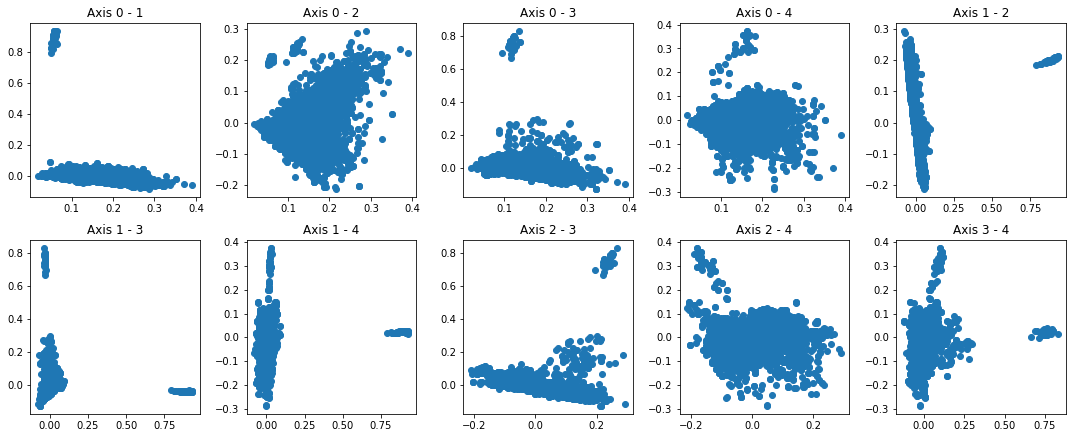

In [19]:
plot_axes(X_red_token, df_articles.uid)

# Let's go deeper into our analysis

We have the newspaper of each article, it would therefore be relevant to see if each of the different newspapers talks about the same topics or not

In [20]:
#Get the newspapers
df_newspapers = pd.read_csv("impresso3.csv", sep=";")
df_newspapers = cleanup(df_newspapers)
df_newspapers = df_newspapers[["uid", "newspaper","year"]]

#Convert to categorical data 
df_newspapers['newspaper'] = pd.Categorical(df_newspapers.newspaper)
df_newspapers['newspaper_id'] = df_newspapers["newspaper"].cat.codes

In [21]:
newspapers = df_newspapers.newspaper.unique()
print(f"We have {len(newspapers)} newspapers in our data which are {newspapers}")

We have 10 newspapers in our data which are ['JDG', 'GDL', 'EXP', 'IMP', 'LSE', 'LLE', 'LLS', 'LCE', 'SDT', 'LES']
Categories (10, object): ['EXP', 'GDL', 'IMP', 'JDG', ..., 'LLE', 'LLS', 'LSE', 'SDT']


In [22]:
def plot_axes_colors(X_red, uid):
    """
    Plot the projected data in 2D with all combination of the different axes
    """
    num_axis = X_red.shape[1]
    fig = plt.figure(figsize=(15, 15))

    count = 1
    for i in range(num_axis):
        for j in range(num_axis):
            if i<j:
                ax = fig.add_subplot(num_axis, num_axis, count)
                scatter = plt.scatter(X_red[:,i], X_red[:,j], c=uid.newspaper_id)
                plt.title(f"Axis {i} - {j}")
                count+=1
                handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
                legend2 = ax.legend(handles, labels, loc="upper right", title="Newspaper")

    fig.tight_layout()

In [23]:
df_newspapers[["newspaper_id","newspaper"]].value_counts()

newspaper_id  newspaper
2             IMP          1542
0             EXP          1513
6             LLE           963
3             JDG           240
1             GDL           142
4             LCE            17
7             LLS             2
5             LES             1
8             LSE             1
9             SDT             1
dtype: int64

We can remove SDT, LSE, LES and LCE due to their very little sample in the data

In [24]:
df_newspapers_filter = df_articles.merge(df_newspapers, on="uid")
df_newspapers_filter = df_newspapers_filter[(df_newspapers_filter["newspaper"] != "SDT") & (df_newspapers_filter["newspaper"] != "LSE") & (df_newspapers_filter["newspaper"] != "LES") & (df_newspapers_filter["newspaper"] != "LCE")  ]

In [25]:
num_axis_uid_filter = 5
X_red_token_filter, VT_token_filter = project_SVD(df_newspapers_filter.uid, uid_to_index, uid_token_tfidf,dim=num_axis_uid_filter)

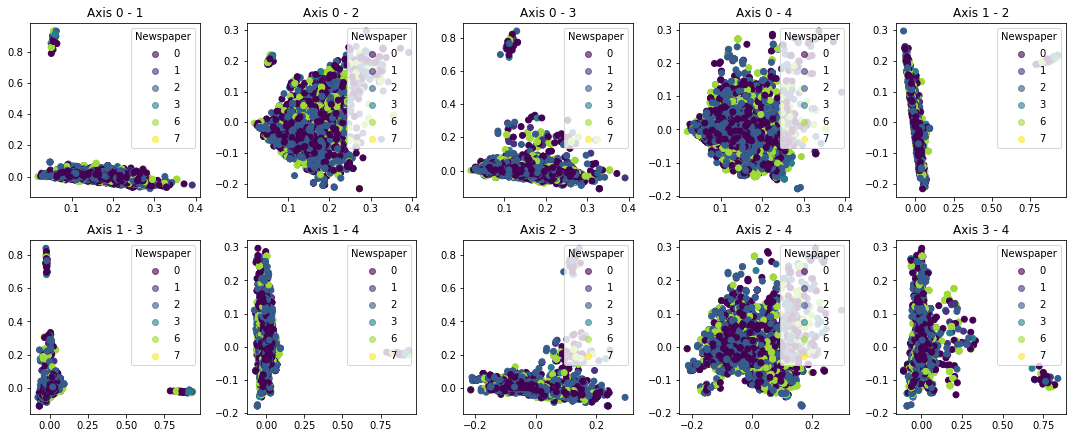

In [26]:
plot_axes_colors(X_red_token_filter, df_newspapers_filter)

In [27]:
#Corresponding colors
df_newspapers[["newspaper_id","newspaper"]].value_counts()

newspaper_id  newspaper
2             IMP          1542
0             EXP          1513
6             LLE           963
3             JDG           240
1             GDL           142
4             LCE            17
7             LLS             2
5             LES             1
8             LSE             1
9             SDT             1
dtype: int64

What happens if we remove one of the most influent (large number of samples/high variance) newspapers?

#### Remove EXP newspaper

In [35]:
#remove EXP
df_articles_no_exp = df_articles.merge(df_newspapers_filter, on="uid")
df_articles_no_exp = df_articles_no_exp[df_articles_no_exp["newspaper"] != "EXP"]


In [36]:
df_articles_no_exp.newspaper.unique()

['JDG', 'GDL', 'IMP', 'LLE', 'LLS']
Categories (10, object): ['EXP', 'GDL', 'IMP', 'JDG', ..., 'LLE', 'LLS', 'LSE', 'SDT']

In [37]:
num_axis_uid_without_exp = 5
X_red_no_exp, VT_token_no_exp = project_SVD(df_articles_no_exp.uid, uid_to_index, uid_token_tfidf,dim=num_axis_uid_without_exp)
get_top_axis(VT_token_no_exp, index_to_token,top_num=5)



The top 5 max values for axis 0 are:
jeu                            0.1958
plus                           0.1876
jeux                           0.1515
console                        0.1454
Nintendo                       0.1261

The top 5 min values for axis 0 are:
ADéveloppement                 -0.0000
ﬁlles                          0.0000
hâtivement                     0.0000
Crackdowm                      0.0000
hébergera                      0.0000



The top 5 max values for axis 1 are:
Gervais                        0.1625
Saint                          0.1318
jeunes                         0.1170
enfants                        0.1102
contes                         0.1038

The top 5 min values for axis 1 are:
Nintendo                       -0.1720
console                        -0.1681
jeu                            -0.1373
Mario                          -0.0941
Xbox                           -0.0816



The top 5 max values for axis 2 are:
Immobilier                     0.2065
Mo

##### Tokens clustering analysis

Based on the top token, we identified the following axes:

| Axis | Max            | Min                |
|------|----------------|--------------------|
| 0    | Video games related | Non frequent words |
| 1    |Real estate      | Nintendo       |
| 2    | Nintendo             |Movie age limitation      |
| 3    | Week       | Video game vocabulary           |
| 4    | Winner of game         | Console        |

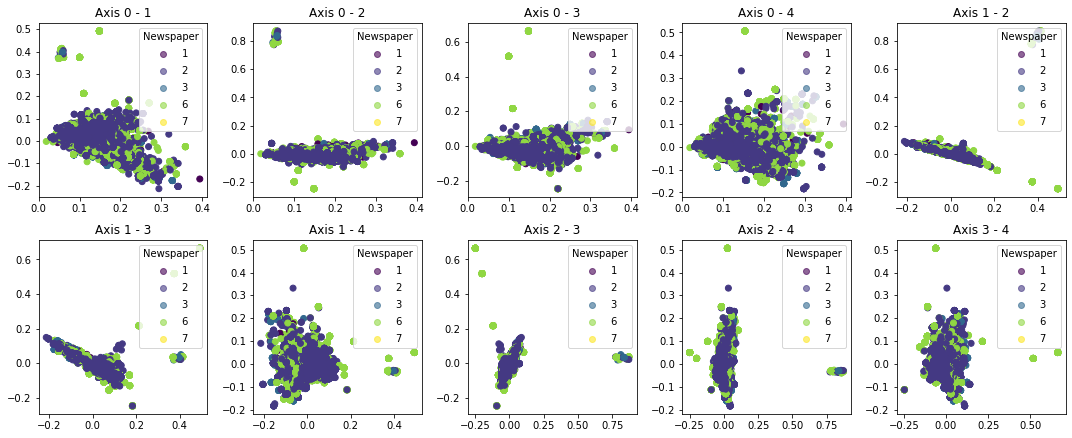

In [38]:
plot_axes_colors(X_red_no_exp, df_articles_no_exp)

Without EXP the cluster still have overall the same shape, let's try now by substracting the two biggest newspapers, also the topics on the main axes are very similar

#### Remove EXP and IMP newspapers

In [39]:
#remove EXP and IMP
df_articles_no_exp_imp = df_articles.merge(df_newspapers_filter, on="uid")
df_articles_no_exp_imp = df_articles_no_exp[(df_articles_no_exp["newspaper"] != "EXP") & (df_articles_no_exp["newspaper"] != "IMP")]


In [40]:
num_axis_uid_without_exp = 5
X_red_no_exp_imp, VT_token_no_exp_imp = project_SVD(df_articles_no_exp_imp.uid, uid_to_index, uid_token_tfidf,dim=num_axis_uid_without_exp)
get_top_axis(VT_token_no_exp_imp, index_to_token,top_num=5)


The top 5 max values for axis 0 are:
jeu                            0.1955
plus                           0.1740
console                        0.1713
jeux                           0.1522
Nintendo                       0.1365

The top 5 min values for axis 0 are:
AIcos                          -0.0000
AGenève                        -0.0000
ADéveloppement                 -0.0000
APGlâne                        -0.0000
lesfrais                       0.0000



The top 5 max values for axis 1 are:
Gervais                        0.3127
Saint                          0.2251
contes                         0.1877
Tombée                         0.1460
conteurs                       0.1429

The top 5 min values for axis 1 are:
console                        -0.0767
Nintendo                       -0.0609
jeu                            -0.0588
Super                          -0.0338
Sega                           -0.0312



The top 5 max values for axis 2 are:
Immobilier                     0.2304

##### Tokens clustering analysis

Based on the top token, we identified the following axes:

| Axis | Max            | Min                |
|------|----------------|--------------------|
| 0    | Video games related | Non frequent word |
| 1    |Fairy    | Console        |
| 2    | Real estate             |Fairy      |
| 3    | Youngsters       | Nintendo          |
| 4    | Utilities        | Pragmatic        |

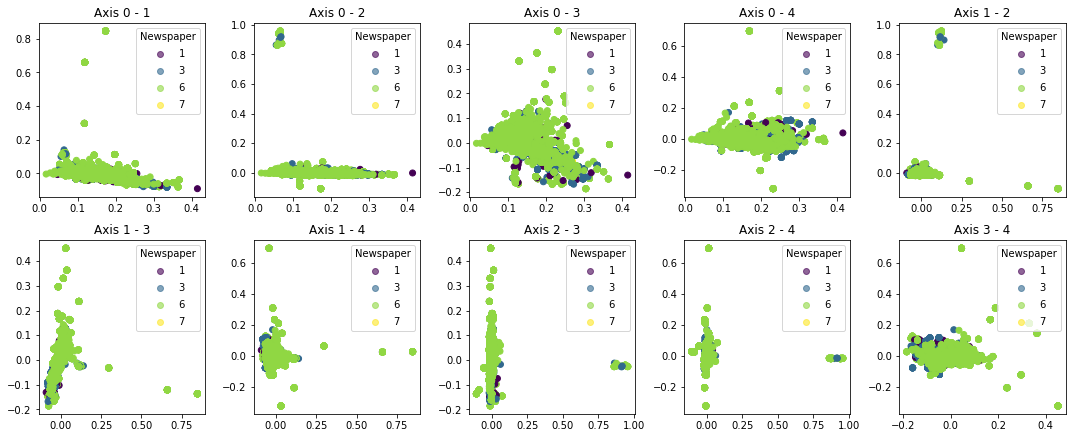

In [41]:
plot_axes_colors(X_red_no_exp_imp, df_articles_no_exp_imp)

We still observe more or less the same shape for the cluster, meaning that big newspapers actually talk overall about the same subjects than the smaller ones.<br>Nevertheless, we observe for some topics that they start drifting away, this can be seen in the plot for the Axis 1-3 and Axis 3-4 plot for instance where the form and inclination of the clusters is starting to change.

# What happens if we actually do this considering time?


## Let's split this data in 3 periods 

The first one is 20 years, the second one also 20 years and the third one 14 years

In [126]:
df = df[["uid","year","content"]]

#First 20 years
df_articles_first = df[(df["year"] < 1984) & (df["year"] >= 1964)]

#Second 20 years
df_articles_second = df[(df["year"] < 2004) & (df["year"] >= 1984)]

#Third 20 years
df_articles_third = df[(df.year <= 2018) & (df.year >= 2004)]


### 1964-1984

In [114]:
num_axis_time= 3
X_red_first, VT_token_first = project_SVD(df_articles_first.uid, uid_to_index, uid_token_tfidf,dim=num_axis_time)
get_top_axis(VT_token_first, index_to_token,top_num=5)


The top 5 max values for axis 0 are:
console                        0.2418
Mega                           0.1954
Drive                          0.1898
jeux                           0.1754
Sega                           0.1553

The top 5 min values for axis 0 are:
ACNielsen                      -0.0000
ANNIVERSAIREPour               -0.0000
AInrs                          -0.0000
désirée                        -0.0000
irrémédiables                  -0.0000



The top 5 max values for axis 1 are:
Tél                            0.6381
fr                             0.1067
électronique                   0.1024
cherche                        0.0977
appartement                    0.0785

The top 5 min values for axis 1 are:
console                        -0.1345
Drive                          -0.1344
Mega                           -0.1287
Sega                           -0.0680
cartouch                       -0.0677



The top 5 max values for axis 2 are:
Tél                            0.601

### 1984-2004

In [111]:
num_axis_time= 3
X_red_second, VT_token_second = project_SVD(df_articles_second.uid, uid_to_index, uid_token_tfidf,dim=num_axis_time)
get_top_axis(VT_token_second, index_to_token,top_num=5)


The top 5 max values for axis 0 are:
jeu                            0.2301
plus                           0.1827
Nintendo                       0.1674
console                        0.1611
jeux                           0.1471

The top 5 min values for axis 0 are:
ADéveloppement                 -0.0000
ANDRé                          -0.0000
ﬁlles                          0.0000
ignorée                        0.0000
Othello                        0.0000



The top 5 max values for axis 1 are:
Immobilier                     0.2110
Mots                           0.2051
Annonces                       0.2015
Canton                         0.2007
Décès                          0.2006

The top 5 min values for axis 1 are:
jeu                            -0.0227
Nintendo                       -0.0190
console                        -0.0171
Mario                          -0.0111
titre                          -0.0102



The top 5 max values for axis 2 are:
semaine                        0.2546
G

### 2004-2018

In [138]:
num_axis_time= 3
X_red_third, VT_token_third = project_SVD(df_articles_third.uid, uid_to_index, uid_token_tfidf,dim=num_axis_time)
get_top_axis(VT_token_third, index_to_token,top_num=5)


The top 5 max values for axis 0 are:
plus                           0.1971
jeu                            0.1496
jeux                           0.1458
an                             0.1368
vidéo                          0.1132

The top 5 min values for axis 0 are:
schwytzoise                    0.0000
laids                          0.0000
ajouteront                     0.0000
rfa                            0.0000
laindre                        0.0000



The top 5 max values for axis 1 are:
Dolby                          0.3268
stéréo                         0.3095
di                             0.2686
suisse                         0.1785
ve                             0.1733

The top 5 min values for axis 1 are:
jeu                            -0.0721
jeux                           -0.0445
console                        -0.0413
tout                           -0.0354
Nintendo                       -0.0342



The top 5 max values for axis 2 are:
jeu                            0.2387
Wii

We observe by doing this that clearly the vocabulary evolves through the years and the most influential words also. The consoles change, as we can see in the early days of video game we have the Mega and Sega along with rustic words used at the time such as "cartouche" (game cartridge) and "electronique", as time goes by we observe a change as new consoles appear such as "Wii" and "Xbox" but also more modern words such as the franchise Mario/Nintendo and "simulation/circuit". <br/>
Therefore we can conclude that over the years, the most influential words in articles evolve while style being in the domain of video games they are different.

# Interactive plot to see article distribution in space with associated year and newspaper

In [85]:
import bokeh
import bokeh.plotting as bpl
from bokeh.plotting import figure, output_file, show, save
from bokeh.palettes import Turbo256, Plasma, cividis, magma
from bokeh.models import LabelSet,Scatter,HoverTool, WheelZoomTool, PanTool, BoxZoomTool, ResetTool, TapTool, SaveTool, OpenURL
from bokeh.models.callbacks import CustomJS
from bokeh.transform import factor_cmap

def get_mean_distance_to_center(Y, newspaper):
    """
    Compute the mean absolute distance of the article of each newspaper to the center of the group (in 2D).
    Y: np.array(article, 2) location of the article in a 2D space.
    newspaper: Corresponding newspapers.
    """
    
    df = pd.DataFrame(
        {
            "x": Y[:, 0],
            "y": Y[:, 1],
            "newspaper": newspaper
        }
    )
    
    mean_per_group = df.groupby("newspaper").mean()
    df = df.join(mean_per_group,on ="newspaper", rsuffix="_mean")
    df["diff"] = np.abs(df["x"] - df["x_mean"]) + np.abs(df["y"] - df["y_mean"])
    return df.groupby("newspaper")["diff"].mean().sort_values()

def plot_scatter_bokeh(Y, newspaper_in_group, visible_by_default = False):
    """
    Create a 2D map of the article.
    """
    df = pd.DataFrame(
        {
            "x": Y[:, 0],
            "y": Y[:, 1],
            "group": newspaper_in_group.newspaper,
            "year": newspaper_in_group.year,
        }
    )
    
    df.loc[:, df.columns != 'group'] = df.loc[:, df.columns != 'group'].fillna("-")

    # Compute clustering index
    group_mean_distance = get_mean_distance_to_center(Y, newspaper_in_group.newspaper)
    group_cluster_ranking = list(group_mean_distance[group_mean_distance.notna()].index)
    
    df['group'] = pd.Categorical(df['group'], categories=group_cluster_ranking, ordered=True)
        
    top_culster_group = group_cluster_ranking[:10]
    
     # Show info on hover
    hover = HoverTool(tooltips=[('Newspaper', '@group'),('Year','@year')])
    tools = [hover, WheelZoomTool(), PanTool(), BoxZoomTool(), ResetTool(), SaveTool(), TapTool()]

    groups = df['group'].unique()
    color_map = factor_cmap("group", factors=sorted(groups),palette=magma(len(groups)))

    # create figure and plot
    p = bpl.figure(height=1000, width=1500, tools=tools)
   

    for group_name,points in df.groupby('group'):
        
        if len(points) != 0:

            source = bpl.ColumnDataSource(points)
  
            
            # Display article
            scat = p.scatter(x='x', y='y',
                      fill_color= color_map,
                      line_color = color_map,
                       source=source)

            if not visible_by_default:
                scat.visible = group_name in top_culster_group
            else:
                scat.visible = True 

    # Define legend size
    p.legend.label_text_font_size = '16px'
    #Padding on the overall rectangle
    p.legend.padding = 0
    p.legend.spacing = 0
    #Size of circular points
    p.legend.glyph_height = 16
    p.legend.glyph_width = 16
    #Padding between label entries
    p.legend.label_height = 0
    p.legend.label_width = 0
    
    # Generate the graph
    bpl.show(p)
    return p

In [86]:
num_axis_uid_without_exp = 5
X_red_no_exp_imp, VT_token_no_exp_imp = project_SVD(df_articles_no_exp_imp.uid, uid_to_index, uid_token_tfidf,dim=num_axis_uid_without_exp)

In [87]:
AXIS_1 = 1
AXIS_2 = 4

p = plot_scatter_bokeh(X_red_no_exp_imp[:,[AXIS_1,AXIS_2]],df_articles_no_exp_imp)
output_file(f'cluster_axis_{AXIS_1}_{AXIS_2}.html',mode='inline')
save(p)

'C:\\Users\\hugol\\Downloads\\ml-project-2-turboml\\cluster_axis_1_4.html'

# WordCloud - Simple plot of most present words in the corpus

## Let's see if a visual representation of the most present word in the articles over the years adds any valuable information to our analysis

Code taken from:
    https://app.neptune.ai/o/neptune-ml/org/eda-nlp-tools/n/4-0-wordclouds-853dfded-4d17-4f37-83e4-15ec53f74e60/5833b046-3cf9-4c0f-8fbf-4a5933da924e

In [128]:
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
import nltk

def plot_wordcloud(text):
    nltk.download('stopwords')
    stop=set(stopwords.words('french'))

    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=30,
        max_font_size=30, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
 
    plt.imshow(wordcloud)
    plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hugol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


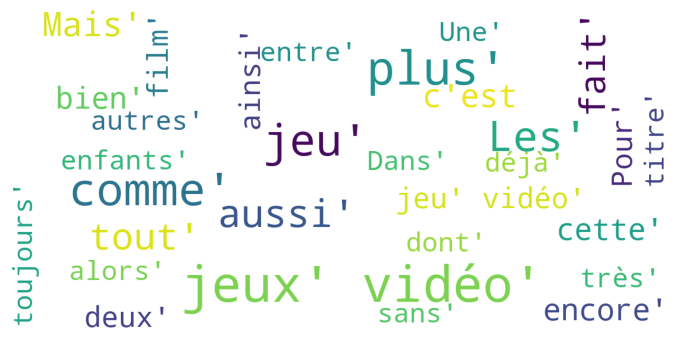

In [129]:
df_cloud = pd.read_csv("impresso3.csv", sep=";")
df_cloud = cleanup(df_cloud)
plot_wordcloud(df_cloud["content"])

### First 20 years

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hugol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


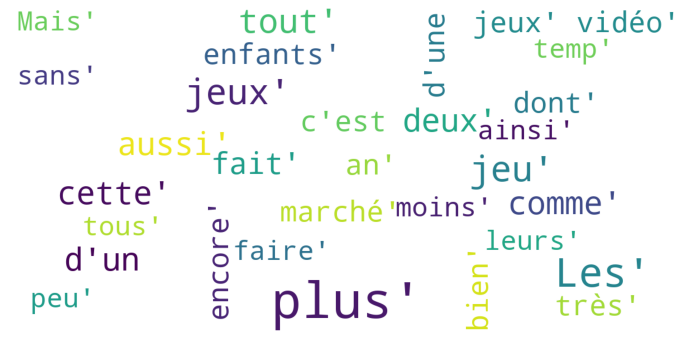

In [130]:
plot_wordcloud(df_articles_first["content"])

### Second 20 years

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hugol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


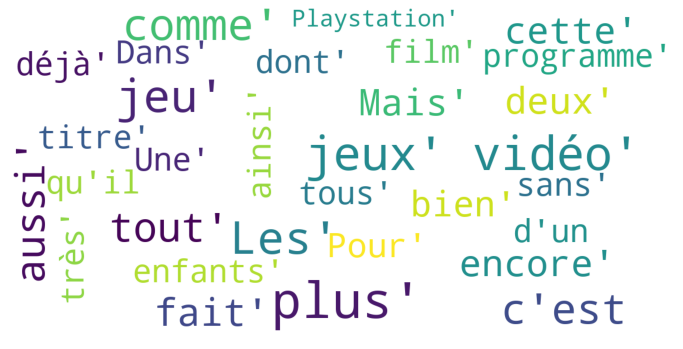

In [131]:
plot_wordcloud(df_articles_second["content"])

### Last 14 years

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hugol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


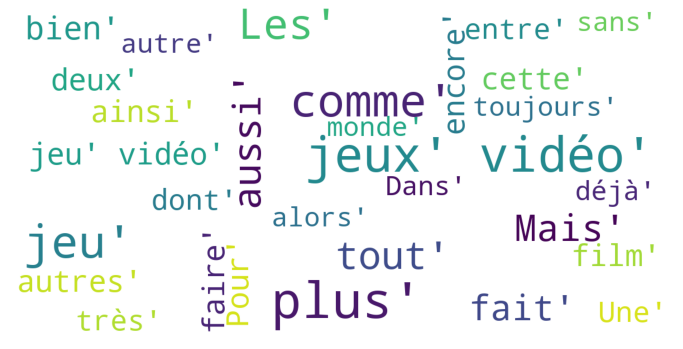

In [132]:
plot_wordcloud(df_articles_third["content"])

# Here is an example that just by plotting the most frequent words the additional information is quite shallow.